In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

In [5]:
data = pd.read_csv('bq-results-20240807-042436-1723005043253.csv')
print(data.head())
print(data.dtypes)

/var/folders/p4/0qyllg6d5lxf0bt1rr7rfrx4rh2ztf/T/ipykernel_42910/2394794770.py:1: DtypeWarning: Columns (9,12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('bq-results-20240807-042436-1723005043253.csv')


                    company_desc CHANNEL_STATUS SOURCE_STATUS  \
0  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
1  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
2  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
3  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
4  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   

   marketplace_name store_code store_name  ORDER_DATE order_time ORDER_NUMBER  \
0               NaN    INVALID    INVALID  2024-06-20   22:39:42   1411417272   
1               NaN    INVALID    INVALID  2024-03-23   14:14:19   1411371540   
2               NaN    INVALID    INVALID  2024-06-20   16:26:41   1411417190   
3               NaN    INVALID    INVALID  2024-06-20   16:26:41   1411417190   
4               NaN    INVALID    INVALID  2024-06-21   03:22:57   1411417297   

                           EMAIL  customer_id MEMBER_TYPE   ITEM_CODE  \
0         singgihsry@hotmail.com     424226.0    

In [6]:
#Data cleaning

missing_values = data.isnull().sum()
print(missing_values)

df = pd.DataFrame(data)
print(df.head())
df = df.dropna(subset=['customer_id'])
df.drop(columns=['marketplace_name'], inplace=True)

missing_values = df.isnull().sum()
print('missing_values', missing_values)

print(df.head())


company_desc              0
CHANNEL_STATUS            0
SOURCE_STATUS             0
marketplace_name    1857758
store_code                0
store_name                0
ORDER_DATE                0
order_time               12
ORDER_NUMBER              0
EMAIL               1380324
customer_id         1380324
MEMBER_TYPE               0
ITEM_CODE                 0
ITEM_NAME                 0
NETT_AMOUNT              19
QUANTITY                 19
TIER                      0
REGISTER_DATE       1380324
dtype: int64
                    company_desc CHANNEL_STATUS SOURCE_STATUS  \
0  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
1  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
2  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
3  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   
4  PT JDSPORTS FASHION INDONESIA         ONLINE       JDSPORT   

   marketplace_name store_code store_name  ORDER_DATE order_time ORDER_NUMBER  \
0          

In [7]:
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

today = datetime.now()

recency_freq = df.groupby('customer_id').agg({
    'NETT_AMOUNT' : 'sum',
    'ORDER_DATE' : lambda x: (today - x.max()).days, 
    'ORDER_NUMBER': pd.Series.nunique #total transactions
}).rename(columns={'NETT_AMOUNT' : 'Total Sales', 'ORDER_DATE' : 'Recency', 'ORDER_NUMBER':'Frequency'})

recency_freq['Last Order Date'] = df.groupby('customer_id')['ORDER_DATE'].max()
recency_freq['Total Visits'] = df.groupby('customer_id')['ORDER_DATE'].nunique()
recency_freq['ATV'] = recency_freq['Total Sales'] / recency_freq['Frequency']
recency_freq['Sales per Visit'] = recency_freq['Total Sales'] / recency_freq['Total Visits']
recency_freq['Last Order Date'] = pd.to_datetime(recency_freq['Last Order Date'])

print('recency freq: ', recency_freq.head())
print('recency freq size: ', recency_freq.shape)

print('Summary Statistics: ', recency_freq.describe())


recency freq:               Total Sales  Recency  Frequency Last Order Date  Total Visits  \
customer_id                                                                  
2.0             600000.0      777          1      2022-07-15             1   
15.0           1549000.0      576          1      2023-02-01             1   
17.0           1020000.0      676          1      2022-10-24             1   
155.0          5765700.0      204          3      2024-02-08             3   
266.0          4926600.0      125          4      2024-04-27             3   

                   ATV  Sales per Visit  
customer_id                              
2.0           600000.0         600000.0  
15.0         1549000.0        1549000.0  
17.0         1020000.0        1020000.0  
155.0        1921900.0        1921900.0  
266.0        1231650.0        1642200.0  
recency freq size:  (119675, 7)
Summary Statistics:          Total Sales        Recency      Frequency  \
count  1.196750e+05  119675.000000  11

In [8]:
# Function to find and count outliers
def find_outliers(df, multiplier=1.5):
    outliers = {}
    outliers_count = {}

    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        outliers_removed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        outliers_found = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print('low bound: ', lower_bound)
        lower_percentile = (df[column] <= lower_bound).mean() * 100
        upper_percentile = (df[column] <= upper_bound).mean() * 100

        
    return outliers_removed, outliers_found, lower_percentile, upper_percentile

cleaned_data, outliers_df, lower_percentile, upper_percentile = find_outliers(recency_freq, multiplier=1.5)

print("Original data:", recency_freq.shape[0])
print("Outliers Data:", outliers_df.shape[0])
print("Outliers Data Summary Statistics:", outliers_df.describe())
print(cleaned_data.head())


print(f"Lower Bound Percentile: {lower_percentile:.2f}%")
print(f"Upper Bound Percentile: {upper_percentile:.2f}%")


low bound:  -1750000.0
low bound:  -350.0
low bound:  -0.5
low bound:  -0.5
low bound:  -967379.1666666664
low bound:  -1041000.0
Original data: 119675
Outliers Data: 4477
Outliers Data Summary Statistics:         Total Sales      Recency    Frequency                Last Order Date  \
count  4.477000e+03  4477.000000  4477.000000                           4477   
mean   1.658494e+07   300.941479     5.280768  2023-11-03 01:24:16.243019776   
min    3.599200e+06    30.000000     1.000000            2022-03-03 00:00:00   
25%    4.100000e+06   134.000000     1.000000            2023-06-11 00:00:00   
50%    4.978000e+06   250.000000     1.000000            2023-12-24 00:00:00   
75%    7.896000e+06   446.000000     2.000000            2024-04-18 00:00:00   
max    2.722356e+09   911.000000  1182.000000            2024-07-31 00:00:00   
std    9.359763e+07   207.676715    33.931824                            NaN   

       Total Visits           ATV  Sales per Visit  
count   4477.000000 

              Recency  Frequency
customer_id                     
2.0          2.201901  -0.175642
15.0         1.254053  -0.175642
17.0         1.725619  -0.175642
155.0       -0.500173   0.303232
266.0       -0.872711   0.542669
401.0       -0.745388  -0.175642
761.0       -0.165361  -0.175642
1010.0      -0.801976  -0.175642
1103.0      -0.500173   0.063795
1616.0       1.235190  -0.175642
Summary Statistics:              Recency     Frequency
count  1.151980e+05  1.151980e+05
mean   7.697680e-17  1.258275e-17
std    1.000004e+00  1.000004e+00
min   -1.320699e+00 -1.756422e-01
25%   -8.208384e-01 -1.756422e-01
50%   -2.502433e-01 -1.756422e-01
75%    7.070361e-01  6.379486e-02
max    2.961122e+00  1.482753e+02


python(43380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


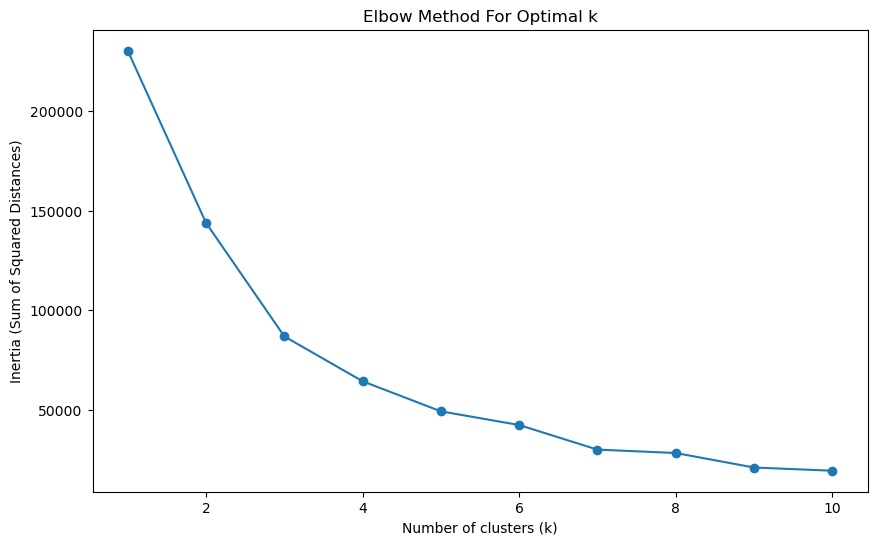

In [9]:
#K-means Recency and Frequency
from datetime import datetime 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


numeric_columns = ['Recency', 'Frequency']
scaler = StandardScaler()
cleaned_data_scaled = scaler.fit_transform(cleaned_data[numeric_columns])
cleaned_data_scaled_df = pd.DataFrame(cleaned_data_scaled, index=cleaned_data.index, columns=numeric_columns)

print(cleaned_data_scaled_df.head(10))
print('Summary Statistics: ', cleaned_data_scaled_df.describe())

rec_freq_columns = ['Recency', 'Frequency']
rec_freq_scaled = cleaned_data_scaled_df[rec_freq_columns]

#Elbow Method 
inertia = []
K = range(1, 11)

#Kmeans
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cleaned_data_scaled)
    inertia.append(kmeans.inertia_)

# Plotting Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

Cluster Centers (scaled):
[[-6.28318761e-01  3.95890972e-02]
 [ 1.18646347e+00 -1.02174230e-01]
 [-1.21942414e+00  5.21584491e+01]]
Cluster Centers (original scale):
[[176.8255851    1.89890551]
 [561.66704269   1.30683613]
 [ 51.47619048 219.57142857]]


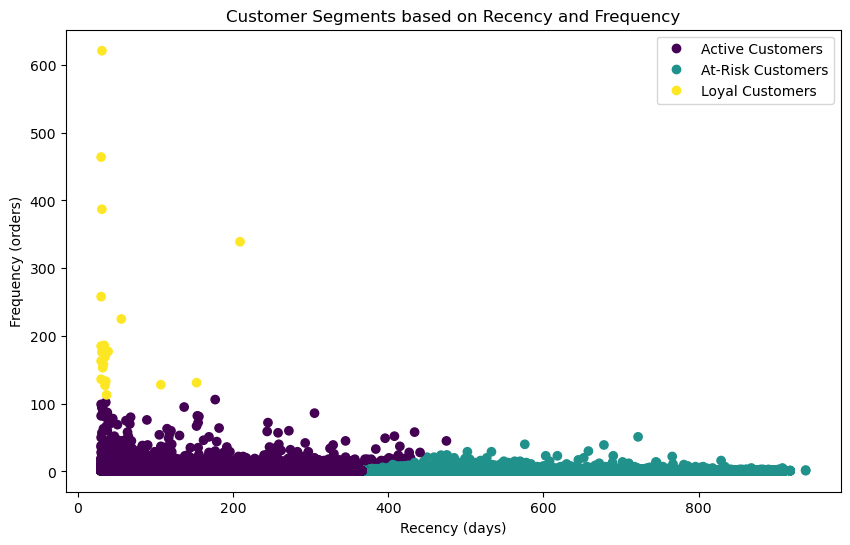

RF_Cluster_Name
Active Customers     75286
At-Risk Customers    39891
Loyal Customers         21
Name: count, dtype: int64

In [10]:
#K-means 
cleaned_data = cleaned_data.copy()
kmeans = KMeans(n_clusters=3, random_state=42)
cleaned_data['RF_Cluster'] = kmeans.fit_predict(cleaned_data_scaled)

print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)
   
print("Cluster Centers (original scale):")
print(scaler.inverse_transform(kmeans.cluster_centers_))

#Visualize
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cleaned_data['Recency'], cleaned_data['Frequency'], c=cleaned_data['RF_Cluster'], cmap='viridis')
legend_labels = {0: 'Active Customers', 1: 'At-Risk Customers', 2: 'Loyal Customers'}
plt.legend(handles=scatter.legend_elements()[0], labels=[legend_labels[i] for i in range(3)])
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (orders)')
plt.title('Customer Segments based on Recency and Frequency')
plt.show()

cluster_names = {0: 'Active Customers', 1: 'At-Risk Customers', 2: 'Loyal Customers'}
cleaned_data['RF_Cluster_Name'] = cleaned_data['RF_Cluster'].map(cluster_names)

cleaned_data["RF_Cluster_Name"].value_counts()

                  ATV
customer_id          
2.0         -0.899882
15.0         0.402915
17.0        -0.323302
155.0        0.914836
266.0       -0.032747
401.0        0.196993
761.0        0.393580
1010.0       1.020679
1103.0      -1.025288
1616.0      -0.290354
Summary Statistics:                  ATV
count  1.151980e+05
mean   5.054070e-16
std    1.000004e+00
min   -1.723568e+00
25%   -8.226581e-01
50%   -7.756879e-02
75%    6.445924e-01
max    3.217176e+00


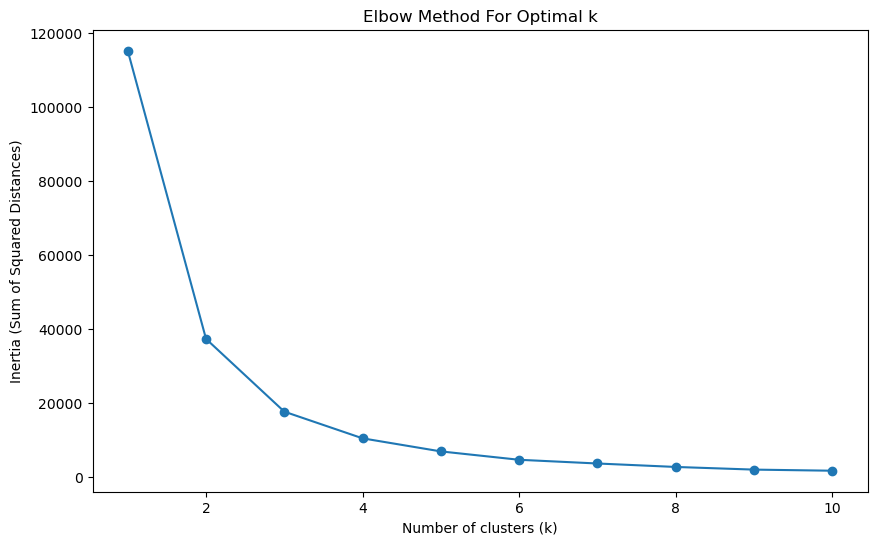

Cluster Centers (scaled):
[[-0.72810017]
 [ 0.92873618]]
Cluster Centers (original scale):
[[ 725131.62839899]
 [1932025.5057737 ]]
 Low Value Customers:
ATV Range: 0.0 to 1328570.0

 High Value Customers:
ATV Range: 1328600.0 to 3599000.0



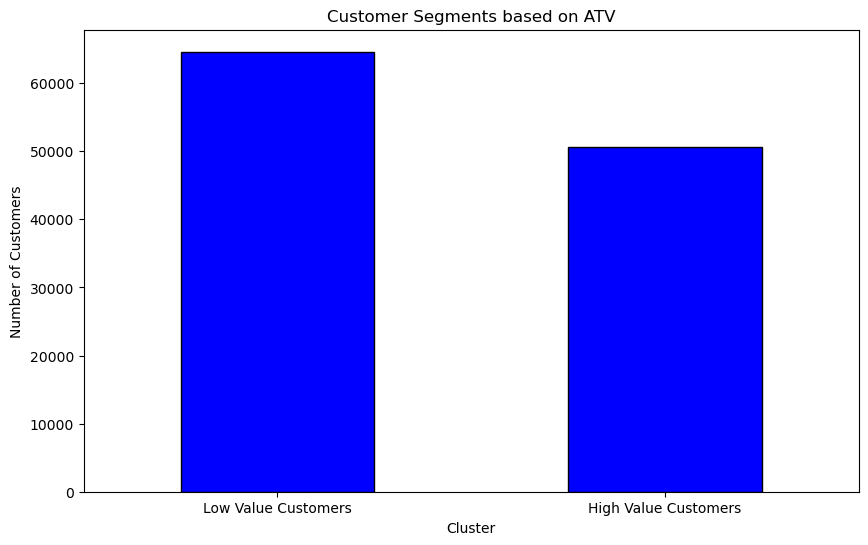

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


numeric_columns = ['ATV']
scaler = StandardScaler()
Freq_ATV_cleaned_data_scaled = scaler.fit_transform(cleaned_data[numeric_columns])
Freq_ATV_cleaned_data_scaled_df = pd.DataFrame(Freq_ATV_cleaned_data_scaled, index=cleaned_data.index, columns=numeric_columns)

print(Freq_ATV_cleaned_data_scaled_df.head(10))
print('Summary Statistics: ', Freq_ATV_cleaned_data_scaled_df.describe())

# Elbow Method
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Freq_ATV_cleaned_data_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

#K-means 
cleaned_data = cleaned_data.copy()
kmeans = KMeans(n_clusters=2, random_state=42)
cleaned_data['Monetary_Cluster'] = kmeans.fit_predict(Freq_ATV_cleaned_data_scaled)

print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)
   
print("Cluster Centers (original scale):")
print(scaler.inverse_transform(kmeans.cluster_centers_))

cluster_labels = {0: 'Low Value Customers', 1: 'High Value Customers'}
cleaned_data['Monetary_Cluster_Label'] = cleaned_data['Monetary_Cluster'].map(cluster_labels)
sorted_labels = ['Low Value Customers', 'High Value Customers']

for cluster in range(2):
    cluster_data = cleaned_data[cleaned_data['Monetary_Cluster'] == cluster]
    min_atv = cluster_data['ATV'].min()
    max_atv = cluster_data['ATV'].max()
    print(f" {cluster_labels[cluster]}:")
    print(f"ATV Range: {min_atv} to {max_atv}")
    print("")
    
#Visualize
plt.figure(figsize=(10, 6))
cleaned_data['Monetary_Cluster_Label'].value_counts().reindex(sorted_labels).plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customer Segments based on ATV')
plt.xticks(rotation=360)
plt.show()

In [12]:
ATV_cluster_names = {0: 'Low Value Customers', 1: 'High Value Customers'}
cleaned_data['Monetary_Cluster_Name'] = cleaned_data['Monetary_Cluster'].map(ATV_cluster_names)

cleaned_data["Monetary_Cluster_Name"].value_counts()

Monetary_Cluster_Name
Low Value Customers     64626
High Value Customers    50572
Name: count, dtype: int64

In [13]:
print(cleaned_data.head())

             Total Sales  Recency  Frequency Last Order Date  Total Visits  \
customer_id                                                                  
2.0             600000.0      777          1      2022-07-15             1   
15.0           1549000.0      576          1      2023-02-01             1   
17.0           1020000.0      676          1      2022-10-24             1   
155.0          5765700.0      204          3      2024-02-08             3   
266.0          4926600.0      125          4      2024-04-27             3   

                   ATV  Sales per Visit  RF_Cluster    RF_Cluster_Name  \
customer_id                                                              
2.0           600000.0         600000.0           1  At-Risk Customers   
15.0         1549000.0        1549000.0           1  At-Risk Customers   
17.0         1020000.0        1020000.0           1  At-Risk Customers   
155.0        1921900.0        1921900.0           0   Active Customers   
266.0    

In [14]:
print(cleaned_data["RF_Cluster_Name"].value_counts())

combination_mapping = {
    ('At-Risk Customers', 'Low Value Customers'): 'A',
    ('At-Risk Customers', 'High Value Customers'): 'B',
    ('Active Customers', 'Low Value Customers'): 'C',
    ('Active Customers', 'High Value Customers'): 'D',
    ('Loyal Customers', 'Low Value Customers'): 'E',
    ('Loyal Customers', 'High Value Customers'): 'F'
}

# Creating New Segment Column
cleaned_data['Segment'] = cleaned_data.apply(
    lambda row: combination_mapping[(row['RF_Cluster_Name'], row['Monetary_Cluster_Name'])], axis=1
)

# Display the updated DataFrame
print(cleaned_data[['RF_Cluster_Name', 'Monetary_Cluster_Name', 'Segment']].head())


RF_Cluster_Name
Active Customers     75286
At-Risk Customers    39891
Loyal Customers         21
Name: count, dtype: int64
               RF_Cluster_Name Monetary_Cluster_Name Segment
customer_id                                                 
2.0          At-Risk Customers   Low Value Customers       A
15.0         At-Risk Customers  High Value Customers       B
17.0         At-Risk Customers   Low Value Customers       A
155.0         Active Customers  High Value Customers       D
266.0         Active Customers   Low Value Customers       C


python(43385) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


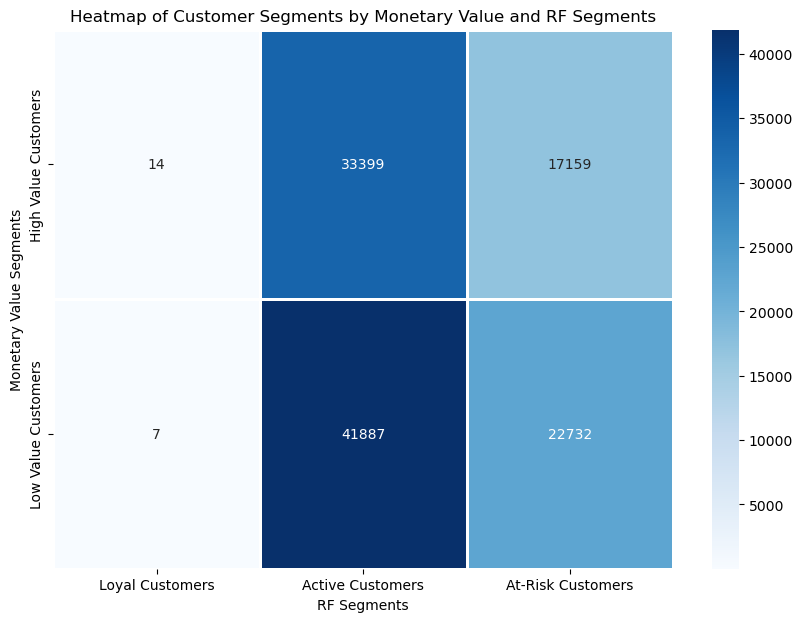

In [15]:
import seaborn as sns
cleaned_data['RF_Cluster_Name'] = pd.Categorical(cleaned_data['RF_Cluster_Name'], categories=['Loyal Customers', 'Active Customers', 'At-Risk Customers']) 
segment_crosstab = pd.crosstab(cleaned_data['Monetary_Cluster_Name'], 
                               cleaned_data['RF_Cluster_Name'])

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(segment_crosstab, annot=True, fmt="d", cmap="Blues", linewidths=.75)
plt.title('Heatmap of Customer Segments by Monetary Value and RF Segments')
plt.ylabel('Monetary Value Segments')
plt.xlabel('RF Segments')
plt.show()